## When do we need medical experts to annotate relations between drugs and diseases?
---

In [1]:
import pandas as pd

In [2]:
expert_table = pd.read_csv('expert_table.csv')
worker_table = pd.read_csv('worker_table.csv')

---
## Workers vs experts (merging consensus tables)

In [3]:
label_list = ['Contraindication','Effect','IDK','Indication: Symptomatic Relief','Indication: Treatment']
match_table = pd.merge(worker_table.drop(columns=label_list),
                       expert_table.drop(columns=label_list),
                       on=['disease_name','drug_name','context'], how='inner')

match_table['relation_match'] = match_table.worker_consensus == match_table.expert_consensus

In [4]:
match_table.head(3)

,disease_name,drug_name,context,worker_answers,inter_agree_workers,worker_consensus,expert_answers,inter_agree_experts,expert_consensus,relation_match
0,ACNE,TAZAROTENE,Retinoids may cause fetal harm when administer...,3,0.666667,Effect,2,1.000000,Indication: Treatment,False
1,ACUTE CERVICITIS,LEVONORGESTREL,['The use of LILETTA is contraindicated when o...,3,0.666667,Contraindication,3,1.000000,Contraindication,True
2,ACUTE INTERMITTENT PORPHYRIA,Hemin,PANHEMATIN is a hemin for injection indicated ...,3,0.666667,Indication: Symptomatic Relief,3,0.666667,Indication: Symptomatic Relief,True


In [5]:
match_table.shape

(334, 10)

In [6]:
match_table.worker_consensus.unique()

array(['Effect', 'Contraindication', 'Indication: Symptomatic Relief',
       'Indication: Treatment', 'No consensus'], dtype=object)

In [7]:
match_table.expert_consensus.unique()

array(['Indication: Treatment', 'Contraindication',
       'Indication: Symptomatic Relief', 'Effect', 'No consensus', 'IDK'],
      dtype=object)

---
### Check matches and workers accuracy

In [8]:
from pycm import *
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
match_table_filtered = match_table[(match_table.worker_consensus != 'No consensus') & 
                                    (match_table.expert_consensus != 'No consensus') &
                                    (match_table.worker_consensus != 'IDK') &
                                    (match_table.expert_consensus != 'IDK')]

In [10]:
y_actu = list(match_table_filtered.expert_consensus) #gold standard # X axis
y_pred = list(match_table_filtered.worker_consensus) #workers answers Y axis
cm = ConfusionMatrix(y_actu, y_pred) 

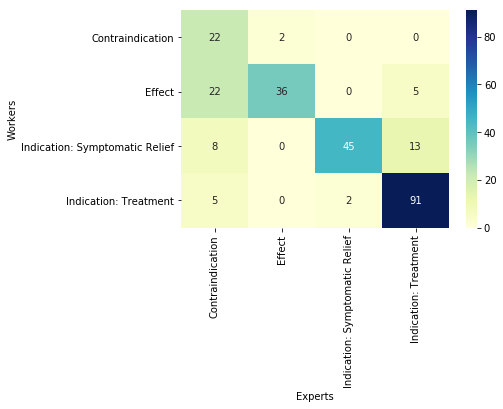

In [11]:
#plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(cm.table), annot=True, cmap="YlGnBu")
plt.xlabel('Experts'); plt.ylabel('Workers'); plt.show()

In [12]:
cm.ACC

{'Contraindication': 0.852589641434263,
 'Effect': 0.8844621513944223,
 'Indication: Symptomatic Relief': 0.9083665338645418,
 'Indication: Treatment': 0.900398406374502}

**Workers find more diffult to annotate contraindication the most**

In [13]:
print('Workers were as good as medical experts in {}% of the cases'.format(round(cm.Overall_ACC*100,2)))

Workers were as good as medical experts in 77.29% of the cases


---
## Questions:
### - What are the characteristics of contexts that makes diffucult for the crowd to have consensus?
### - Can we train a ML method that learns when the crowd will perform as good as the experts?

Temptative features to be extracted
- lenght of text
- number of words
- particular words used on medical domain misinterpreted
- amount of medical terminology
- multiple concepts at once
- long distance between disease, drug and relation

Tenmptative groups to analyze
- Excluding the No concensus of the experts, analyze the miss match of workers
- All those answers with match, compare the label match vs concensus match
- Where do experts disagree but workers don't

---

In [14]:
#text lenght
match_table['total_characters'] = [len(text) for text in match_table['context']]
match_table['total_words'] = [len(text.replace('\n',' ').split()) for text in match_table['context']]

In [15]:
match_table.to_csv('experts_vs_crowd_working_table.csv',index=False)

In [16]:
subset_consensus = match_table[(match_table.expert_consensus != 'No consensus') & (match_table.expert_consensus != 'IDK')]

In [17]:
subset_consensus.groupby('relation_match').describe().T#.reset_index()

relation_match                   False        True 
worker_answers      count    88.000000   194.000000
                    mean      3.000000     3.000000
                    std       0.000000     0.000000
                    min       3.000000     3.000000
                    25%       3.000000     3.000000
                    50%       3.000000     3.000000
                    75%       3.000000     3.000000
                    max       3.000000     3.000000
inter_agree_workers count    88.000000   194.000000
                    mean      0.571970     0.881443
                    std       0.195406     0.159985
                    min       0.333333     0.666667
                    25%       0.333333     0.666667
                    50%       0.666667     1.000000
                    75%       0.666667     1.000000
                    max       1.000000     1.000000
expert_answers      count    88.000000   194.000000
                    mean      2.829545     2.175258
                    std       0.551312     0.690578
                    min       1.000000     1.000000
                    25%       3.000000     2.000000
                    50%       3.000000     2.000000
                    75%       3.000000     3.000000
                    max       5.000000     4.000000
inter_agree_experts count    88.000000   194.000000
                    mean      0.824242     0.955756
                    std       0.169194     0.112911
                    min       0.600000     0.666667
                    25%       0.666667     1.000000
                    50%       0.666667     1.000000
                    75%       1.000000     1.000000
                    max       1.000000     1.000000
total_characters    count    88.000000   194.000000
                    mean    980.068182   973.912371
                    std     686.037109   752.534583
                    min     126.000000    81.000000
                    25%     452.000000   430.250000
                    50%     828.000000   704.500000
                    75%    1435.750000  1323.250000
                    max    3060.000000  3511.000000
total_words         count    88.000000   194.000000
                    mean    130.500000   130.742268
                    std      90.025156    99.810471
                    min      19.000000    11.000000
                    25%      60.500000    54.750000
                    50%     111.000000    98.500000
                    75%     179.000000   175.750000
                    max     371.000000   393.000000

## Statistical difference in means

In [18]:
subset_matches = subset_consensus[subset_consensus['relation_match']==True]
subset_missmatches = subset_consensus[subset_consensus['relation_match']==False]

In [19]:
from scipy import stats

average workers interate agreement on success: 0.8814432989690721
average workers interate agreement on failure: 0.571969696969697


Ttest_indResult(statistic=13.010009881547083, pvalue=5.673571132214459e-26)

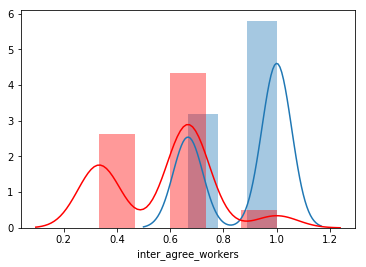

In [20]:
# T-test with different means, variance, and n:
workers_succeed = subset_matches.inter_agree_workers
workers_failed = subset_missmatches.inter_agree_workers
sns.distplot(workers_succeed)
sns.distplot(workers_failed, color='r')
print('average workers interate agreement on success: {}\naverage workers interate agreement on failure: {}'\
          .format(workers_succeed.mean(),workers_failed.mean()))
stats.ttest_ind(workers_succeed, workers_failed, equal_var = False)

**Workers perform as good as experts when there is more agreement among workers**

average experts interate agreement on success: 0.9557560137457045
average experts interate agreement on failure: 0.8242424242424242


Ttest_indResult(statistic=6.650787757548445, pvalue=8.441111361272022e-10)

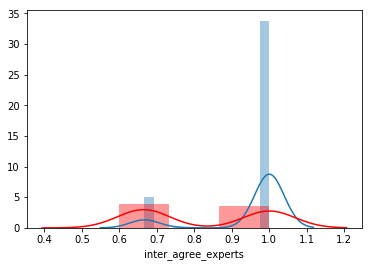

In [21]:
# T-test with different means, variance, and n:
workers_succeed = subset_matches.inter_agree_experts
workers_failed = subset_missmatches.inter_agree_experts
sns.distplot(workers_succeed)
sns.distplot(workers_failed, color='r')
print('average experts interate agreement on success: {}\naverage experts interate agreement on failure: {}'\
          .format(workers_succeed.mean(),workers_failed.mean()))
stats.ttest_ind(workers_succeed, workers_failed, equal_var = False)

**Workers perform as good as experts when there is more agreement among experts also**

average total words on success: 130.7422680412371
average total words on failure: 130.5


Ttest_indResult(statistic=0.020227803325365754, pvalue=0.983883433846657)

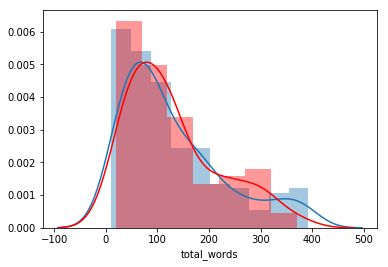

In [22]:
# T-test with different means, variance, and n:
workers_succeed = subset_matches.total_words
workers_failed = subset_missmatches.total_words
sns.distplot(workers_succeed)
sns.distplot(workers_failed, color='r')
print('average total words on success: {}\naverage total words on failure: {}'\
          .format(workers_succeed.mean(),workers_failed.mean()))
stats.ttest_ind(workers_succeed, workers_failed, equal_var = False)

**It does not matter the number of words in the text on workers successes**

average total characters on success: 973.9123711340206
average total characters on failure: 980.0681818181819


Ttest_indResult(statistic=-0.06770198896467464, pvalue=0.9460966678116258)

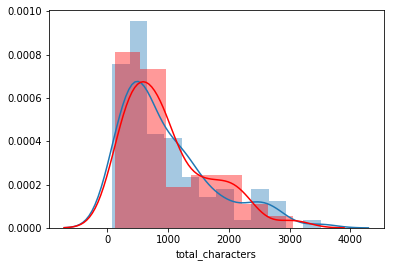

In [23]:
# T-test with different means, variance, and n:
workers_succeed = subset_matches.total_characters
workers_failed = subset_missmatches.total_characters
sns.distplot(workers_succeed)
sns.distplot(workers_failed, color='r')
print('average total characters on success: {}\naverage total characters on failure: {}'\
          .format(workers_succeed.mean(),workers_failed.mean()))
stats.ttest_ind(workers_succeed, workers_failed, equal_var = False)

**It does not matter the lenght of characters in the text on workers successes**

---
### Can we predict the crowd will perform as good as an expert based on the features

In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# split data into X and y
X = subset_consensus._get_numeric_data().drop(columns=['relation_match','inter_agree_experts','expert_answers'])
Y = subset_consensus['relation_match']
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.60%


In [25]:
cmx = ConfusionMatrix([float(i ==True) for i in y_test], list(predictions)) 

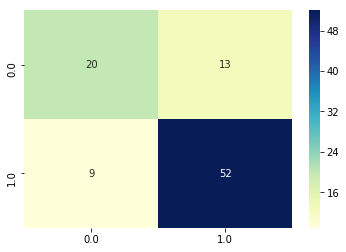

In [26]:
sns.heatmap(pd.DataFrame(cmx.table), annot=True, cmap="YlGnBu")